In [ ]:
import argparse
import os, sys
import json
import numpy as np
import time

import WhiskiWrap as ww
from WhiskiWrap import load_whisker_data as lwd
# add directory above notebook to path
sys.path.append(os.path.dirname(os.path.abspath('')))
import whiskerpad as wp
# Check that whisk binaries are executables and update permissions if necessary
from wwutils.whisk_permissions import update_permissions
update_permissions()

In [ ]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
input_dir= Path('/home/wanglab/data/whisker_asym/wa001/test')
# Path('/data')

# list all the files in the data directory
# data_files = list(input_dir.glob('*'))
# print(data_files)
video_name='WA001_080224_01_TopCam_10s.mp4' 
# 'sc016_0630_001_30sWhisking.mp4'
base_name='WA001_080224_01'
# 'sc016_0630_001'
input_file=input_dir/video_name

# load the video's first frame 
# frame_num = 0
# cap = cv2.VideoCapture(str(input_file))
# cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
# ret, frame = cap.read()
# cap.release()
# # display the image,
# plt.imshow(frame)
# plt.axis('off')
# plt.show()

# # Save the image as base_name_first_frame.png
# output_file = input_dir / f'{base_name}_first_frame.png'
# cv2.imwrite(str(output_file), frame)

In [ ]:
# # Flip the video along the x-axis (vertical flip) and save it
# output_file = input_dir / f'{base_name}_north.mp4'
# cap = cv2.VideoCapture(str(input_file))
# width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter(str(output_file), fourcc, 30, (width, height))
# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break
#     frame = cv2.flip(frame, 0)
#     out.write(frame)
# cap.release()
# out.release()

# # Rotate the video 90 degrees cw and save it
# output_file = input_dir / f'{base_name}_west.mp4'
# cap = cv2.VideoCapture(str(input_file))
# width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter(str(output_file), fourcc, 30, (height, width))    
# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break
#     frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
#     out.write(frame)
# cap.release()
# out.release()

# # Rotate the video 90 degrees ccw and save it
# output_file = input_dir / f'{base_name}_east.mp4'
# cap = cv2.VideoCapture(str(input_file))
# width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter(str(output_file), fourcc, 30, (height, width))
# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break
#     frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
#     out.write(frame)
# cap.release()
# out.release()

# # Also save the video as is
output_file = input_dir / f'{base_name}_south.mp4'
cap = cv2.VideoCapture(str(input_file))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(str(output_file), fourcc, 30, (width, height))
while True:
    ret, frame = cap.read()
    if not ret:
        break
    out.write(frame)
cap.release()
out.release()

#### Run whisker tracking on the first frame

In [ ]:
splitUp=True
# output_dir = input_dir / 'frame_0_whiskers'
nproc=40

**For vertical whisker tracking (including made-up flip version):**

In [ ]:
# whiskerpad=wp.Params(str(input_file), splitUp, base_name)
# whiskerpadParams, splitUp = wp.WhiskerPad.get_whiskerpad_params(whiskerpad)
# Oriented to the south
direction = 'south'
# Define input file here if testing different orientations
input_file = input_dir / f'{base_name}_{direction}.mp4'
image_halves, image_side, face_side, fp = wp.get_side_image(str(input_file), splitUp)
#  Oriented to the north
# direction = 'north'
# input_file = input_dir / f'{base_name}_{direction}.mp4'
# image_halves, image_side, face_side, fp = wp.get_side_image(str(input_file), splitUp)
# image_halves = [cv2.flip(h, 0) for h in image_halves]

# print each image halves side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_halves[0], cmap='gray')
ax[0].axis('off')
ax[0].set_title(f"Face side: {face_side[0]}, Image side: {image_side[0]}")
ax[1].imshow(image_halves[1], cmap='gray')
ax[1].axis('off')
ax[1].set_title(f"Face side: {face_side[1]}, Image side: {image_side[1]}")
plt.show()

# Save each side as tif
output_dir = input_dir / f"frame_0_whiskers_vertical_{direction}"
output_dir.mkdir(exist_ok=True)
for i, side in enumerate(image_side):
    output_file = output_dir / f'{base_name}_first_frame_{side}.tif'
    cv2.imwrite(str(output_file), image_halves[i])

**For horizontal whisker tracking:** 

In [ ]:
# make laternative set of images, rotating the images 90 degrees
# to the west
# direction = 'west'
# input_file = input_dir / f'{base_name}_{direction}.mp4'
# image_halves, image_side, face_side, fp = wp.get_side_image(str(input_file), splitUp)
# image_halves_rotated = [np.rot90(image_halves[1], k=-1), np.rot90(image_halves[0], k=-1)]
# or to the east
direction = 'east' 
input_file = input_dir / f'{base_name}_{direction}.mp4'
image_halves, image_side, face_side, fp = wp.get_side_image(str(input_file), splitUp)
# image_halves_rotated = [np.rot90(image_halves[0], k=1), np.rot90(image_halves[1], k=1)]
# rotated_face_side = ['bottom', 'top']

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
# ax[0].imshow(image_halves_rotated[0], cmap='gray')
ax[0].imshow(image_halves[0], cmap='gray')
ax[0].axis('off')
ax[0].set_title(f"Face side: {face_side[0]}, Image side: {image_side[0]}")
# ax[0].set_title(f"Face side: {rotated_face_side[0]}")
ax[1].imshow(image_halves[1], cmap='gray')
# ax[1].imshow(image_halves_rotated[1], cmap='gray')
ax[1].axis('off')
ax[1].text(0.5, -0.1, f"Face side: {face_side[1]}, Image side: {image_side[1]}", size=12, ha="center", 
         transform=ax[1].transAxes)
# ax[1].set_title(f"Face side: {rotated_face_side[1]}")

plt.show()

# Save each side as tif
output_dir = input_dir / f"frame_0_whiskers_horizontal_{direction}"
output_dir.mkdir(exist_ok=True)
# for i, side in enumerate(rotated_face_side):
for i, side in enumerate(image_side):
    output_file = output_dir / f'{base_name}_first_frame_{side}.tif'
    # cv2.imwrite(str(output_file), image_halves_rotated[i])
    cv2.imwrite(str(output_file), image_halves[i])

In [ ]:
# Load whiskerpad json file
whiskerpad_file = os.path.join(input_dir, f'whiskerpad_{base_name}.json')
# whiskerpad_file = os.path.join(input_dir, f'whiskerpad_{os.path.basename(input_file).split(".")[0]}.json')

if not os.path.exists(whiskerpad_file):
# If whiskerpad file does not exist, create it
    print('Creating whiskerpad parameters file.')
    whiskerpad=wp.Params(input_file, splitUp, base_name)
    # Get whiskerpad parameters
    whiskerpadParams, splitUp = wp.WhiskerPad.get_whiskerpad_params(whiskerpad)
    # Save whisking parameters to json file
    wp.WhiskerPad.save_whiskerpad_params(whiskerpad, whiskerpadParams)

with open(whiskerpad_file, 'r') as f:
    whiskerpad_params = json.load(f)

# Check that left and right whiskerpad parameters are defined
if np.size(whiskerpad_params['whiskerpads'])<2:
    raise Exception('Missing whiskerpad parameters in whiskerpad json file.')

# Get side types (left / right or top / bottom)
# side_types = [whiskerpad['FaceSide'].lower() for whiskerpad in whiskerpad_params['whiskerpads']]
im_side_types = [whiskerpad['ImageSide'].lower() for whiskerpad in whiskerpad_params['whiskerpads']]
# face image side defined by ImageBorderAxis !!
im_face_side_types = [whiskerpad['ImageBorderAxis'].lower() for whiskerpad in whiskerpad_params['whiskerpads']]

# side_types = face_side # rotated_face_side
# side_types = image_side

print(f"Image face sides {im_face_side_types} for image sides {im_side_types}, with direction: {direction}")

In [ ]:
#######################
### Run whisker tracking
########################

for im_side, im_face_side in zip(im_side_types, im_face_side_types):
    print(f'Running whisker tracking for {im_side} image side video')
    plt.imshow(image_halves[image_side.index(im_side)], cmap='gray')
    # plt.imshow(image_halves_rotated[
    #     rotated_face_side.index(side)], cmap='gray')
    plt.axis('off')
    plt.title(f"Face image side: {im_face_side}")
    plt.show()
    # Time the tracking
    start_time_track = time.time()

    image_filename = output_dir / f'{base_name}_first_frame_{im_side}.tif' # _left _bottom _right _top
    result_dict = ww.trace_and_measure_chunk(image_filename,
                                            delete_when_done=False,
                                            face=im_face_side)
    # ,
                                            # classify={'px2mm': '0.04', 'n_whiskers': '3'})
    

    time_track = time.time() - start_time_track
    print(f'Tracking took {time_track} seconds.')

In [ ]:
# Load the whisker data and plot whiskers on each image
# whiskers is a list of dictionaries, each dictionary is a frame, each frame has a dictionary of whiskers
# side_types=['left', 'right'] # ['bottom', 'top']
# output_dir = input_dir / 'WT'

# Initialize the dictionary to store the whisker data for each side
whisker_data = {}

for im_side in im_side_types:
    print(f'Loading whiskers for {im_side} face side video')
    whisk_filename = output_dir / f'{base_name}_first_frame_{im_side}.whiskers'
    # whisk_filename = output_dir / f'{base_name}_{im_side}_00000000.whiskers'
    # Load whiskers for the first frame
    whiskers = ww.wfile_io.Load_Whiskers(str(whisk_filename))
    whisker_data[im_side] = {0: whiskers[0]}

print(f"Whisker data for {len(whisker_data)} sides loaded.")

In [ ]:
# Initialize the dictionaries to store the whisker pixel values for each side
xpixels, ypixels = {}, {}
# whisker_ids = {}

for im_side, whiskers in whisker_data.items():
    # Initialize lists for this side if they don't exist yet
    if im_side not in xpixels:
        xpixels[im_side] = []
    if im_side not in ypixels:
        ypixels[im_side] = []
    # if side not in whisker_ids:
    #     whisker_ids[side] = []
    
    for frame, frame_whiskers in list(whiskers.items()):
        for whisker_id, wseg in list(frame_whiskers.items()):
            # Write whisker contour x and y pixel values
            xpixels[im_side].append(wseg.x)
            ypixels[im_side].append(wseg.y)
            # whisker_ids[side].append(wseg.id)    

In [ ]:
# Check how many whiskers were detected for each side
n_whiskers = {side: len(xpixels[side]) for side in im_side_types}
print(f"Number of whiskers detected: {n_whiskers}")
# print(f"Whisker IDs for each sides: {whisker_ids}")

In [ ]:
# Get unique whisker IDs
whisker_ids = {side: np.unique([wseg.id for frame_whiskers in whisker_data[side].values() for wseg in frame_whiskers.values()]) for side in im_side_types}
print(f"Unique whisker IDs: {whisker_ids}")
# Create set of colors for each whisker ID
colors = {side: plt.cm.viridis(np.linspace(0, 1, len(whisker_ids[side]))) for side in im_side_types}

In [ ]:
# whisker_x = xpixels[im_side]
# len(whisker_x)
# whisker_id
for whisker_id, color in zip(whisker_ids[im_side], colors[im_side]):
    print(f"Whisker ID: {whisker_id}, color: {color}")
# xpixels[im_side]

In [ ]:
# Plot whiskers on each image

# define image orientation
if 'top' in im_side_types or 'bottom' in im_side_types:
    im_orientation = 'horizontal'
elif 'left' in im_side_types or 'right' in im_side_types:
    im_orientation = 'vertical'

if im_orientation == 'horizontal':
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    # Remove space between subplots
    plt.subplots_adjust(wspace=0, hspace=-0.05)
elif im_orientation == 'vertical':
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # Remove space between subplots
    plt.subplots_adjust(wspace=-0.51, hspace=0)

for i, im_side in enumerate(im_side_types):
    if im_orientation == 'vertical':
        ax[-(i+1)].imshow(image_halves[i], cmap='gray')
    elif im_orientation == 'horizontal':
        # ax[i].imshow(image_halves_rotated[i], cmap='gray')
        ax[i].imshow(image_halves[i], cmap='gray')
    # for whisker_id, color in zip(whisker_ids[im_side], colors[im_side]):
    for idx, (whisker_id, color) in enumerate(zip(whisker_ids[im_side], colors[im_side])):
        # Get the whisker pixel values for this whisker ID from xpixels and ypixels
        whisker_x = xpixels[im_side][idx] # whisker_id
        whisker_y = ypixels[im_side][idx] # whisker_id
        if im_orientation == 'vertical':
            ax[-(i+1)].plot(whisker_x, whisker_y, color=color)
        elif im_orientation == 'horizontal':
            ax[i].plot(whisker_x, whisker_y, color=color)
    if im_orientation == 'vertical':
        ax[-(i+1)].axis('off')
        ax[-(i+1)].set_title(f"Face image side: {im_side}")
    elif im_orientation == 'horizontal':    
        ax[i].axis('off')
        if i == 0:
            ax[i].set_title(f"Face image side: {im_side}")
        elif i == 1:
            ax[i].text(0.5, -0.1, f"Face image side: {im_side}", size=12, ha="center", transform=ax[i].transAxes)
                       
plt.show()

In [ ]:
#  Check if measurement file exists
measurement_file = output_dir / f'{base_name}_first_frame_{im_side}.measurements'
# output_dir = input_dir / 'WT'
# measurement_file = output_dir / f'{base_name}_{im_side}_00000000.measurements'
if measurement_file.exists():
    wmeas = {}
    for im_side in im_side_types:
        print(f'Loading whisker measurements for {im_side} image side video')
        whisk_filename = output_dir / f'{base_name}_first_frame_{im_side}.whiskers'
        # whisk_filename = output_dir / f'{base_name}_{im_side}_00000000.whiskers'
        # Load whiskers
        wmeas[im_side] =ww.read_whisker_data(str(whisk_filename), 'df')

print(f"Whisker measurements for {len(wmeas)} sides loaded.")

In [ ]:
wmeas['left']
# wmeas['top']

# "initial" is already very different from the original measurements done on first frame ...
# But at least length and pixel_length are close. That's not true for the classify measurements.

In [ ]:
# as sanity check, for each whisker, (on each side), compute whisker length and compare to the length in the measurements file
# Initialize the dictionaries to store the whisker lengths for each side
whisker_lengths, whisker_lengths_meas = {}, {}
for im_side in im_side_types:
    # Initialize lists for this side if they don't exist yet
    if im_side not in whisker_lengths:
        whisker_lengths[im_side] = []
    
    for frame, frame_whiskers in list(whisker_data[im_side].items()):
        for whisker_id, wseg in list(frame_whiskers.items()):
            # Compute whisker length
            whisker_length = np.sqrt((wseg.x[-1] - wseg.x[0])**2 + (wseg.y[-1] - wseg.y[0])**2)
            whisker_lengths[im_side].append(whisker_length)

# Compare whisker lengths to lengths in measurements file
for im_side in im_side_types:
    if im_side not in whisker_lengths_meas:
        whisker_lengths_meas[im_side] = []
    # # Get whisker lengths from measurements file 
    #  # Sort the whisker lengths according to the sorted indices
    # sorted_indices = np.argsort(wmeas[im_side]['label'])
    # whisker_lengths_meas[im_side].append(np.array(wmeas[im_side]['length'])[sorted_indices])
    
    # # Compare whisker lengths
    # whisker_lengths_diff = np.array(whisker_lengths[im_side]) - np.array(whisker_lengths_meas[im_side])
    
    # Get whisker lengths from measurements file 
    sorted_indices = np.argsort(wmeas[im_side]['label'])
    whisker_lengths_meas[im_side] = np.array(wmeas[im_side]['length'])[sorted_indices]
    
    # Compare whisker lengths
    whisker_lengths_diff = np.array(whisker_lengths[im_side]) - whisker_lengths_meas[im_side]
    
    print(f"Mean difference in whisker lengths for {im_side} face side: {np.mean(whisker_lengths_diff)}")
    print(f"Max difference in whisker lengths for {im_side} face side: {np.max(np.abs(whisker_lengths_diff))}")

In [ ]:
# Print arrays
print(np.array(whisker_lengths[im_side]))
print( np.array(whisker_lengths_meas[im_side]))

In [ ]:
#  print 'score' for each whisker from measurements data (wmeas), for each side. again, resort by labels
# Initialize the dictionaries to store the whisker scores for each side
whisker_scores = {}
for im_side in im_side_types:
    # Initialize lists for this side if they don't exist yet
    if im_side not in whisker_scores:
        whisker_scores[im_side] = []
    
    sorted_indices = np.argsort(wmeas[im_side]['label'])
    whisker_scores[im_side].append(np.array(wmeas[im_side]['score'])[sorted_indices])

# Print whisker scores
for im_side in im_side_types:
    print(f"Whisker lengths and scores for {im_side} image side:")
    
    for length, score in zip(whisker_lengths[im_side], whisker_scores[im_side][0]):
        print(f"{length}, {score}")

In [ ]:
# Normalize the scores to be between 0 and 1
for im_side in im_side_types:
    whisker_scores[im_side] = np.array(whisker_scores[im_side][0])
    whisker_scores[im_side] = (whisker_scores[im_side] - np.min(whisker_scores[im_side])) / (np.max(whisker_scores[im_side]) - np.min(whisker_scores[im_side]))

In [ ]:
# define image orientation
if 'top' in im_side_types or 'bottom' in im_side_types:
    im_orientation = 'horizontal'
elif 'left' in im_side_types or 'right' in im_side_types:
    im_orientation = 'vertical'

# Get follicles

follicle_x, follicle_y = {}, {}
for im_side in im_side_types:
    # Initialize lists for this side if they don't exist yet
    if im_side not in follicle_x:
        follicle_x[im_side] = []
        follicle_y[im_side] = []
    
    sorted_indices = np.argsort(wmeas[im_side]['label'])
    if im_orientation == 'horizontal':
        follicle_x[im_side].append(np.array(wmeas[im_side]['follicle_x'])[sorted_indices]) #tip_x
        follicle_y[im_side].append(np.array(wmeas[im_side]['follicle_y'])[sorted_indices]) #tip_y
    elif im_orientation == 'vertical':
        follicle_x[im_side].append(np.array(wmeas[im_side]['follicle_x'])[sorted_indices])
        follicle_y[im_side].append(np.array(wmeas[im_side]['follicle_y'])[sorted_indices])

# Flatten the lists
for im_side in im_side_types:
    follicle_x[im_side] = np.concatenate(follicle_x[im_side])
    follicle_y[im_side] = np.concatenate(follicle_y[im_side])

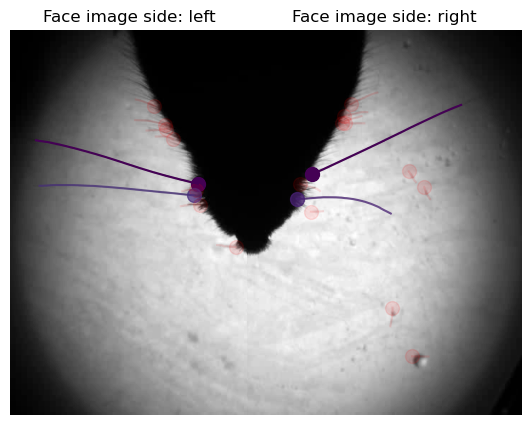

In [32]:
# define image orientation
if 'top' in im_side_types or 'bottom' in im_side_types:
    im_orientation = 'horizontal'
elif 'left' in im_side_types or 'right' in im_side_types:
    im_orientation = 'vertical'

# Plot whiskers on each image
if im_orientation == 'vertical':
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # Remove space between subplots
    plt.subplots_adjust(wspace=-0.51, hspace=0)
elif im_orientation == 'horizontal':
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    # Remove space between subplots
    plt.subplots_adjust(wspace=0, hspace=-0.05)

for i, im_side in enumerate(im_side_types):
    if im_orientation == 'vertical':
        if direction == 'north':
            ax[i].imshow(image_halves[i], cmap='gray')
        elif direction == 'south':
            ax[-(i+1)].imshow(image_halves[i], cmap='gray')
    elif im_orientation == 'horizontal':
        # ax[i].imshow(image_halves_rotated[i], cmap='gray')
        if direction == 'east':
            ax[i].imshow(image_halves[i], cmap='gray')
        elif direction == 'west':
            ax[-(i+1)].imshow(image_halves[i], cmap='gray')

    # Plot the follicles (follicle_x, follicle_y) as circles of the same color as 
    # the corresponding whisker, with intensity defined by whisker scores
    for fx, fy, score, color in zip(follicle_x[im_side],
                                    follicle_y[im_side],
                                    whisker_scores[im_side],
                                    colors[im_side]):
        # If the score is below 0.5, set the color to red
        if score < 0.5:
            color = 'red'
            alpha_level = 0.1
        else:
            alpha_level = score
        if im_orientation == 'vertical':
            if direction == 'north':
                ax[i].scatter(fx, fy, s=100, c=[color], alpha=alpha_level)
            elif direction == 'south':
                ax[-(i+1)].scatter(fx, fy, s=100, c=[color], alpha=alpha_level)
        elif im_orientation == 'horizontal':
            if direction == 'east':
                ax[i].scatter(fx, fy, s=100, c=[color], alpha=alpha_level)
            if direction == 'west':
                ax[-(i+1)].scatter(fx, fy, s=100, c=[color], alpha=alpha_level)

    # Plot the whiskers
    # for whisker_id, score, color in zip(whisker_ids[im_side],
    #                              whisker_scores[im_side],
    #                              colors[im_side]):
    for idx, (whisker_id, score, color) in enumerate(zip(whisker_ids[im_side],
                                                            whisker_scores[im_side],
                                                            colors[im_side])):
        # Get the whisker pixel values for this whisker ID from xpixels and ypixels
        whisker_x = xpixels[im_side][idx] #whisker_id
        whisker_y = ypixels[im_side][idx] #whisker_id
        # If the score is below 0.5, set the color to red
        if whisker_scores[im_side][idx] < 0.5:
            color = 'red'
            alpha_level = 0.1
            # print(f"Whisker ID {whisker_id} for {side} face side has a score of {whisker_scores[side][whisker_id]}.")
        else:
            alpha_level = score
        # alpha_level = 1
        if im_orientation == 'vertical':
            if direction == 'north':
                ax[i].plot(whisker_x, whisker_y, color=color, alpha=alpha_level)
            elif direction == 'south':
                ax[-(i+1)].plot(whisker_x, whisker_y, color=color, alpha=alpha_level)
        elif im_orientation == 'horizontal':
            if direction == 'east':
                ax[i].plot(whisker_x, whisker_y, color=color, alpha=alpha_level)
            elif direction == 'west':
                ax[-(i+1)].plot(whisker_x, whisker_y, color=color, alpha=alpha_level)

    if im_orientation == 'vertical':
        ax[-(i+1)].axis('off')
        ax[-(i+1)].set_title(f"Face image side: {im_side}")
    elif im_orientation == 'horizontal':
        # ax[i].axis('off')
        ax[-(i+1)].axis('off')
        if i == 1:
            # ax[i].set_title(f"Face image side: {im_side}")
            ax[-(i+1)].set_title(f"Face image side: {im_side}")
        elif i == 0:
            # ax[i].text(0.5, -0.1, f"Face side: {im_side}", size=12, ha="center", transform=ax[i].transAxes)
            ax[-(i+1)].text(0.5, -0.1, f"Face side: {im_side}", size=12, ha="center", transform=ax[-(i+1)].transAxes)
        
plt.show()

In [ ]:
# save the figure
output_file = output_dir / f'{base_name}_first_frame_{im_side}_{direction}_whiskers_scores.png'
fig.savefig(output_file, bbox_inches='tight', dpi=300)

In [ ]:
import pandas as pd
# Save whisker lengths and scores to csv
for im_side in im_side_types:
    output_file = output_dir / f'{base_name}_first_frame_{im_side}_{direction}_whisker_lengths_scores.csv'
    # Assuming whisker_lengths and whisker_scores are dictionaries with the same keys
    data = {'length': whisker_lengths[im_side], 'score': whisker_scores[im_side]}
    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False)